In [65]:
import nltk
from konlpy.tag import *
from ckonlpy.tag import Twitter
import MeCab
import kss
from collections import Counter
import tensorflow as tf
import numpy as np
import re
from soynlp.normalizer import *
import hanspell
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import fetch_20newsgroups
import pandas as pd
from math import log
import urllib
import matplotlib as mpl
import matplotlib.pyplot as plt
import json
import os
from pprint import pprint
import platform
from tqdm.notebook import tqdm

plt.style.use("dark_background")

okt = Okt()
kkm = Kkma()
kmr = Komoran()
hnn = Hannanum()
twt = Twitter()

class Mecab:
    def pos(self, text):
        p = re.compile(".+\t[A-Z]+")
        return [tuple(p.match(line).group().split("\t")) for line in MeCab.Tagger().parse(text).splitlines()[:-1]]
    
    def morphs(self, text):
        p = re.compile(".+\t[A-Z]+")
        return [p.match(line).group().split("\t")[0] for line in MeCab.Tagger().parse(text).splitlines()[:-1]]
    
    def nouns(self, text):
        p = re.compile(".+\t[A-Z]+")
        temp = [tuple(p.match(line).group().split("\t")) for line in MeCab.Tagger().parse(text).splitlines()[:-1]]
        nouns=[]
        for word in temp:
            if word[1] in ["NNG", "NNP", "NNB", "NNBC", "NP", "NR"]:
                nouns.append(word[0])
        return nouns
    
mc = Mecab()

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

path = "C:/Windows/Fonts/malgun.ttf"
if platform.system() == "Darwin":
    mpl.rc("font", family="AppleGothic")
elif platform.system() == "Windows":
    font_name = mpl.font_manager.FontProperties(fname=path).get_name()
    mpl.rc('font', family=font_name)
    
mpl.rc("axes", unicode_minus=False)

C:\Users\5CG7092POZ\Anaconda3\envs\tf2.0\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\5CG7092POZ\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\5CG7092POZ\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\5CG7092POZ\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 1. Bag of Words
- Bag of Words란 단어들의 순서는 전혀 고려하지 않고, 단어들의 출현 빈도(frequency)에만 집중하는 텍스트 데이터의 수치화 표현 방법입니다. Bag of Words를 직역하면 단어들의 가방이라는 의미입니다. 단어들이 들어있는 가방을 상상해봅시다. 갖고있는 어떤 텍스트 문서에 있는 단어들을 가방에다가 전부 넣습니다. 그러고나서 이 가방을 흔들어 단어들을 섞습니다. 만약, 해당 문서 내에서 특정 단어가 N번 등장했다면, 이 가방에는 그 특정 단어가 N개 있게됩니다. 또한 가방을 흔들어서 단어를 섞었기 때문에 더 이상 단어의 순서는 중요하지 않습니다.

## 1-1. 직접 구현하기

In [20]:
#정규 표현식을 통해 온점을 제거하는 정제 작업입니다.
token = re.sub("(\.)","","정부가 발표하는 물가상승률과 소비자가 느끼는 물가상승률은 다르다.")  
token = okt.morphs(token)  

word2idx = {}
bow = []
for voca in token:
    if voca not in word2idx.keys():
        # token을 읽으면서, word2idx에 없는 (not in) 단어는 새로 추가하고, 이미 있는 단어는 넘깁니다.
        word2idx[voca] = len(word2idx)
# BoW 전체에 전부 기본값 1을 넣어줍니다. 단어의 개수는 최소 1개 이상이기 때문입니다.
        bow.insert(-1, 1)
    else:
        #재등장하는 단어의 인덱스를 받아옵니다.
        idx = word2idx.get(voca)
        #재등장한 단어는 해당하는 인덱스의 위치에 1을 더해줍니다.(단어의 개수를 세는 것입니다.)
        bow[idx] = bow[idx] + 1

print(word2idx)
print(bow)

{'정부': 0, '가': 1, '발표': 2, '하는': 3, '물가상승률': 4, '과': 5, '소비자': 6, '느끼는': 7, '은': 8, '다르다': 9}
[1, 2, 1, 1, 2, 1, 1, 1, 1, 1]


## 1-2. CountVectorizer 사용하기

In [33]:
corpus = ["you know I want your love. because I love you."]
vect = CountVectorizer()

#코퍼스로부터 각 단어의 빈도 수를 기록한다.
print(vect.fit_transform(corpus).toarray())
#각 단어의 인덱스가 어떻게 부여되었는지를 보여준다.
print(vect.vocabulary_)

[[1 1 2 1 2 1]]
{'you': 4, 'know': 1, 'want': 3, 'your': 5, 'love': 2, 'because': 0}


# 2. TF-IDF

## 2-1. 직접 구현하기

In [2]:
docs = ["먹고 싶은 사과", "먹고 싶은 바나나", "길고 노란 바나나 바나나", "저는 과일이 좋아요"] 
vocab = list(set(word for doc in docs for word in doc.split(" ")))
vocab.sort()

In [3]:
vocab

['과일이', '길고', '노란', '먹고', '바나나', '사과', '싶은', '저는', '좋아요']

### (1) TF

In [20]:
#총 문서의 수
N = len(docs)

def calc_tf(term, doc):
    return doc.count(term)

def calc_idf(term):
    df = 0
    for doc in docs:
        df += term in doc
    return log(N/(df + 1))

def calc_tfidf(term, doc):
    return calc_tf(term, doc)*calc_idf(term)

tf = []
for i in range(N):
    tf.append([])
    doc = docs[i]
    for j in range(len(vocab)):
        term = vocab[j]
        tf[-1].append(calc_tf(term, doc))

tf_df = pd.DataFrame(tf, columns=vocab)

In [21]:
tf_df

,과일이,길고,노란,먹고,바나나,사과,싶은,저는,좋아요
0,0,0,0,1,0,1,1,0,0
1,0,0,0,1,1,0,1,0,0
2,0,1,1,0,2,0,0,0,0
3,1,0,0,0,0,0,0,1,1


### (2) IDF

In [22]:
idf = []
for i in range(len(vocab)):
    term = vocab[i]
    idf.append(calc_idf(term))
idf_ser = pd.Series(idf, index=vocab)

In [23]:
idf_ser

과일이    0.693147
길고     0.693147
노란     0.693147
먹고     0.287682
바나나    0.287682
사과     0.693147
싶은     0.287682
저는     0.693147
좋아요    0.693147
dtype: float64

### (3) TF-IDF

In [24]:
tfidf = []
for i in range(N):
    doc = docs[i]
    tfidf.append([])
    for j in range(len(vocab)):
        term = vocab[j]
        tfidf[-1].append(calc_tfidf(term, doc))
tfidf_df = pd.DataFrame(tfidf, columns=vocab)
tfidf_df

,과일이,길고,노란,먹고,바나나,사과,싶은,저는,좋아요
0,0.000000,0.000000,0.000000,0.287682,0.000000,0.693147,0.287682,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.287682,0.287682,0.000000,0.287682,0.000000,0.000000
2,0.000000,0.693147,0.693147,0.000000,0.575364,0.000000,0.000000,0.000000,0.000000
3,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.693147,0.693147


- 지금까지 TF-IDF의 가장 기본적인 식에 대해서 학습하고, 이를 실제로 구현하는 실습을 진행해보았습니다. 그런데 사실 실제 TF-IDF 구현을 제공하고 있는 많은 패키지들은 패키지마다 식이 조금씩 다르긴 하지만, 위에서 배운 기본 식에서 조정된 식을 사용합니다. 그 이유는 위의 기본적인 식을 바탕으로 한 구현에도 여전히 문제점이 존재하기 때문입니다. 만약 전체 문서의 수 `N=4`인데, `DF=3`인 경우에는 어떤 일이 벌어질까요? `IDF=0`이 됨을 의미합니다. 식으로 표현하면 `IDF = log(N/(DF + 1)) = 0`입니다. IDF의 값이 0이라면 더 이상 가중치의 역할을 수행하지 못합니다. 그래서 실제 구현체는 IDF = log(N/(DF + 1)) + 1과 같이 log항에 1을 더해줘서 log항의 값이 0이 되더라도 IDF가 최소 1이상의 값을 가지도록 합니다. 사이킷런도 이 방식을 사용합니다.

## 1-2. Tensorflow로 구현하기

In [2]:
texts = ["먹고 싶은 사과", "먹고 싶은 바나나", "길고 노란 바나나 바나나", "저는 과일이 좋아요"]
tkn = tf.keras.preprocessing.text.Tokenizer()
tkn.fit_on_texts(texts)

In [4]:
print(tkn.word_index)

{'바나나': 1, '먹고': 2, '싶은': 3, '사과': 4, '길고': 5, '노란': 6, '저는': 7, '과일이': 8, '좋아요': 9}


- 각 단어에 숫자 1부터 시작하는 정수 인덱스가 부여되었습니다. 이제 텍스트 데이터에 `texts_to_matrix()`를 사용해보겠습니다. `texts_to_matrix()`란 이름에서 알 수 있지만, 이 도구는 입력된 텍스트 데이터로부터 행렬(matrix)를 만드는 도구입니다. 총 4개의 모드를 지원하는데 각 모드는 `"count"`, `"binary"`, `"tfidf"`, `"freq"`입니다. 우선 `"count"` 모드를 사용해봅시다.

### (1) `mode="binary"`

In [9]:
print(tkn.texts_to_matrix(texts, mode="binary"))

[[0. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]]


- DTM과 결과가 매우 유사해보입니다. 다만 세번째 행, 두번째 열의 값이 DTM에서는 2였는데 여기서는 1로 바뀌었습니다. 그 이유는 "binary" 모드는 해당 단어가 존재하는지만 관심을 가지고 해당 단어가 몇 개였는지는 무시하기 때문입니다. 해당 단어가 존재하면 1, 단어가 존재하지 않으면 0의 값을 가집니다. 즉, 단어의 존재 유무로만 행렬을 표현합니다.

### (2) `mode="count"`

In [7]:
print(tkn.texts_to_matrix(texts, mode="count"))

[[0. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]]


- "count"를 사용하면 우리가 앞서 배운 문서 단어 행렬(Document-Term Matrix, DTM)을 생성합니다. DTM에서의 인덱스는 앞서 확인한 word_index의 결과입니다.
- 다만 주의할 점은 각 단어에 부여되는 인덱스는 1부터 시작하는 반면에 완성되는 행렬의 인덱스는 0부터 시작합니다. 실제로 단어의 개수는 9개였지만 완성된 행렬의 열의 개수는 10개인 것과 첫번째 열은 모든 행에서 값이 0인 것을 볼 수 있습니다. 인덱스 0에는 그 어떤 단어도 할당되지 않았기 때문입니다.
- 네번째 행을 보겠습니다. 네번째 행은 테스트 데이터에서 네번째 문장을 의미합니다. 네번째 행은 8번째 열, 9번째 열, 10번째 열에서 1의 값을 가집니다. 이는 7번 단어, 8번 단어, 9번 단어가 네번째 문장에서 1개씩 존재함을 의미합니다. 위에서 정수 인코딩 된 결과를 보면 7번 단어는 "저는", 8번 단어는 "과일이", 9번 단어는 "좋아요"입니다. 세번째 행의 첫번째 열의 값은 2인데, 이는 세번째 문장에서 1번 인덱스를 가진 바나나가 두 번 등장했기 때문입니다.
- 앞서 배웠듯이 DTM은 bag of words를 기반으로 하므로 단어 순서 정보는 보존되지 않습니다. 사실 더 구체적으로는 4개의 모든 모드에서 단어 순서 정보는 보존되지 않습니다.

### (3) `mode="tfidf"`

In [11]:
#둘째 자리까지 반올림하여 출력합니다.
print(tkn.texts_to_matrix(texts, mode="tfidf").round(3))

[[0.    0.    0.847 0.847 1.099 0.    0.    0.    0.    0.   ]
 [0.    0.847 0.847 0.847 0.    0.    0.    0.    0.    0.   ]
 [0.    1.435 0.    0.    0.    1.099 1.099 0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.099 1.099 1.099]]


- 말 그대로 TF-IDF 행렬을 만듭니다. 다만, TF-IDF 챕터에서 배운 기본식이나 사이킷런의 TfidfVectorizer에서 사용하는 식이랑 또 조금 다릅니다. TF를 각 문서에서의 각 단어의 빈도에 자연 로그를 씌우고 1을 더한 값으로 정의했습니다. IDF에서는 앞서 배운 기본식에서 로그는 자연 로그를 사용하고, 로그 안의 분수에 1을 추가로 더했습니다. 물론, 이러한 식을 굳이 기억할 필요는 없고 여전히 TF-IDF의 기존 의도를 갖고 있다고 이해하면 됩니다.

### (4) `mode="freq"`

In [14]:
#둘째 자리까지 반올림하여 출력합니다.
print(tkn.texts_to_matrix(texts, mode="freq").round(3))

[[0.    0.    0.333 0.333 0.333 0.    0.    0.    0.    0.   ]
 [0.    0.333 0.333 0.333 0.    0.    0.    0.    0.    0.   ]
 [0.    0.5   0.    0.    0.    0.25  0.25  0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.333 0.333 0.333]]


- 각 문서에서의 각 단어의 등장 횟수를 분자로, 각 문서의 크기(각 문서에서 등장한 모든 단어의 개수의 총 합)를 분모로 하는 표현 방법입니다. 예를 들어 세번째 행을 보겠습니다. 세번째 문장은 "길고 노란 바나나 바나나" 였습니다. 문서의 크기는 4인데, 바나나는 총 2회 등장했습니다. 이에 따라서 세번째 문장에서의 단어 "바나나"의 값은 위의 행렬에서 0.5가 됩니다. 반면에 "길고", "노란"이라는 두 단어는 각 1회 등장했으므로 각자 1/4의 값인 0.25의 값을 가집니다.

# 3. Tensorflow Basics
- 딥러닝 실행 순서
    1. 전처리: 학습에 필요한 데이터 전처리를 수행합니다.  
    2. 모델링(tf.keras.Model): 모델을 정의합니다.  
    3. 컴파일(compile): 모델을 생성합니다.  
    4. 학습 (fit): 모델을 학습시킵니다.
    - 아래는 실제 전처리 - 모델링 - 컴파일 - 학습으로 이어지는 코드를 보여줍니다.

In [24]:
# 데이터 전처리
xs = np.array([-1.0, 0.0, 1.0, 2.0, 3.0, 4.0], dtype=float)
ys = np.array([5.0, 6.0, 7.0, 8.0, 9.0, 10.0], dtype=float)

# 모델의 정의 (tf.keras.Modeling)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=1, input_shape=(1,), activation="relu"))

# 모델의 생성 (compile)
model.compile(optimizer="sgd", loss="mse")

# 학습 (fit)
model.fit(xs, ys, epochs=1200, verbose=0)

# 검증
# 16.000046
model.predict([10.0])

array([[16.000051]], dtype=float32)

## 3-1. Linear Regression 구현하기

### (1) Sequential API

In [57]:
x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
y = np.array([11, 22, 33, 44, 53, 66, 77, 87, 95])

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=1, input_shape=(1,), activation="linear"))

model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.01), loss="mse", metrics=["mse"])

model.fit(x, y, batch_size=1, epochs=300, shuffle=False)

Train on 9 samples
Epoch 1/300
9/9 [==============================] - 1s 132ms/sample - loss: 432.2936 - root_mean_squared_error: 20.7917
Epoch 2/300
9/9 [==============================] - 0s 1ms/sample - loss: 2.4084 - root_mean_squared_error: 1.5519
Epoch 3/300
9/9 [==============================] - 0s 1ms/sample - loss: 2.3983 - root_mean_squared_error: 1.5486
Epoch 4/300
9/9 [==============================] - 0s 2ms/sample - loss: 2.3886 - root_mean_squared_error: 1.5455
Epoch 5/300
9/9 [==============================] - 0s 2ms/sample - loss: 2.3793 - root_mean_squared_error: 1.5425
Epoch 6/300
9/9 [==============================] - 0s 1ms/sample - loss: 2.3704 - root_mean_squared_error: 1.5396
Epoch 7/300
9/9 [==============================] - 0s 1ms/sample - loss: 2.3618 - root_mean_squared_error: 1.5368
Epoch 8/300
9/9 [==============================] - 0s 2ms/sample - loss: 2.3536 - root_mean_squared_error: 1.5342
Epoch 9/300
9/9 [==============================] - 0s 2ms/sample

Epoch 72/300
9/9 [==============================] - 0s 1ms/sample - loss: 2.1671 - root_mean_squared_error: 1.4721
Epoch 73/300
9/9 [==============================] - 0s 1ms/sample - loss: 2.1664 - root_mean_squared_error: 1.4719
Epoch 74/300
9/9 [==============================] - 0s 997us/sample - loss: 2.1657 - root_mean_squared_error: 1.4716
Epoch 75/300
9/9 [==============================] - 0s 1ms/sample - loss: 2.1651 - root_mean_squared_error: 1.4714
Epoch 76/300
9/9 [==============================] - 0s 887us/sample - loss: 2.1644 - root_mean_squared_error: 1.4712
Epoch 77/300
9/9 [==============================] - 0s 997us/sample - loss: 2.1638 - root_mean_squared_error: 1.4710
Epoch 78/300
9/9 [==============================] - 0s 997us/sample - loss: 2.1632 - root_mean_squared_error: 1.4708
Epoch 79/300
9/9 [==============================] - 0s 2ms/sample - loss: 2.1626 - root_mean_squared_error: 1.4706
Epoch 80/300
9/9 [==============================] - 0s 1ms/sample - loss

9/9 [==============================] - 0s 2ms/sample - loss: 2.1462 - root_mean_squared_error: 1.4650
Epoch 213/300
9/9 [==============================] - 0s 1ms/sample - loss: 2.1462 - root_mean_squared_error: 1.4650
Epoch 214/300
9/9 [==============================] - 0s 1ms/sample - loss: 2.1462 - root_mean_squared_error: 1.4650
Epoch 215/300
9/9 [==============================] - 0s 1ms/sample - loss: 2.1462 - root_mean_squared_error: 1.4650
Epoch 216/300
9/9 [==============================] - 0s 1ms/sample - loss: 2.1462 - root_mean_squared_error: 1.4650
Epoch 217/300
9/9 [==============================] - 0s 1ms/sample - loss: 2.1462 - root_mean_squared_error: 1.4650
Epoch 218/300
9/9 [==============================] - 0s 1ms/sample - loss: 2.1462 - root_mean_squared_error: 1.4650
Epoch 219/300
9/9 [==============================] - 0s 997us/sample - loss: 2.1462 - root_mean_squared_error: 1.4650
Epoch 220/300
9/9 [==============================] - 0s 1ms/sample - loss: 2.1462 - 

### (2) Functional API

In [100]:
x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
y = np.array([11, 22, 33, 44, 53, 66, 77, 87, 95])

inputs = tf.keras.Input(shape=(1,))
outputs = tf.keras.layers.Dense(units=1, activation="linear")(inputs)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer="sgd", loss="mse", metrics=["mse"])

model.fit(x, y, batch_size=1, epochs=300, shuffle=False)

Epoch 1/300
9/9 [==============================] - 0s 1ms/step - loss: 459.9264 - mse: 459.9264
Epoch 2/300
9/9 [==============================] - 0s 886us/step - loss: 2.4705 - mse: 2.4705
Epoch 3/300
9/9 [==============================] - 0s 997us/step - loss: 2.4577 - mse: 2.4577
Epoch 4/300
9/9 [==============================] - 0s 1ms/step - loss: 2.4454 - mse: 2.4454
Epoch 5/300
9/9 [==============================] - 0s 1ms/step - loss: 2.4337 - mse: 2.4337
Epoch 6/300
9/9 [==============================] - 0s 1ms/step - loss: 2.4225 - mse: 2.4225
Epoch 7/300
9/9 [==============================] - 0s 886us/step - loss: 2.4117 - mse: 2.4117
Epoch 8/300
9/9 [==============================] - 0s 1ms/step - loss: 2.4014 - mse: 2.4014
Epoch 9/300
9/9 [==============================] - 1s 85ms/step - loss: 2.3916 - mse: 2.3916
Epoch 10/300
9/9 [==============================] - 0s 1ms/step - loss: 2.3821 - mse: 2.3821
Epoch 11/300
9/9 [==============================] - 0s 887us/step - 

9/9 [==============================] - 0s 1ms/step - loss: 2.1607 - mse: 2.1607
Epoch 89/300
9/9 [==============================] - 0s 886us/step - loss: 2.1602 - mse: 2.1602
Epoch 90/300
9/9 [==============================] - 0s 1ms/step - loss: 2.1597 - mse: 2.1597
Epoch 91/300
9/9 [==============================] - 0s 997us/step - loss: 2.1592 - mse: 2.1592
Epoch 92/300
9/9 [==============================] - 0s 997us/step - loss: 2.1588 - mse: 2.1588
Epoch 93/300
9/9 [==============================] - 0s 1ms/step - loss: 2.1584 - mse: 2.1584
Epoch 94/300
9/9 [==============================] - 0s 1ms/step - loss: 2.1580 - mse: 2.1580
Epoch 95/300
9/9 [==============================] - 0s 997us/step - loss: 2.1576 - mse: 2.1576
Epoch 96/300
9/9 [==============================] - 0s 1ms/step - loss: 2.1572 - mse: 2.1572
Epoch 97/300
9/9 [==============================] - 0s 1ms/step - loss: 2.1568 - mse: 2.1568
Epoch 98/300
9/9 [==============================] - 0s 1ms/step - loss: 2.1

9/9 [==============================] - 0s 1ms/step - loss: 2.1468 - mse: 2.1468
Epoch 176/300
9/9 [==============================] - 0s 1ms/step - loss: 2.1468 - mse: 2.1468
Epoch 177/300
9/9 [==============================] - 0s 887us/step - loss: 2.1468 - mse: 2.1468
Epoch 178/300
9/9 [==============================] - 0s 887us/step - loss: 2.1467 - mse: 2.1467
Epoch 179/300
9/9 [==============================] - 0s 887us/step - loss: 2.1467 - mse: 2.1467
Epoch 180/300
9/9 [==============================] - 0s 886us/step - loss: 2.1467 - mse: 2.1467
Epoch 181/300
9/9 [==============================] - 0s 1ms/step - loss: 2.1467 - mse: 2.1467
Epoch 182/300
9/9 [==============================] - 0s 1ms/step - loss: 2.1466 - mse: 2.1466
Epoch 183/300
9/9 [==============================] - 0s 1ms/step - loss: 2.1466 - mse: 2.1466
Epoch 184/300
9/9 [==============================] - 0s 997us/step - loss: 2.1466 - mse: 2.1466
Epoch 185/300
9/9 [==============================] - 0s 1ms/step

9/9 [==============================] - 0s 1ms/step - loss: 2.1461 - mse: 2.1461
Epoch 262/300
9/9 [==============================] - 0s 1ms/step - loss: 2.1461 - mse: 2.1461
Epoch 263/300
9/9 [==============================] - 0s 997us/step - loss: 2.1461 - mse: 2.1461
Epoch 264/300
9/9 [==============================] - 0s 997us/step - loss: 2.1461 - mse: 2.1461
Epoch 265/300
9/9 [==============================] - 0s 1ms/step - loss: 2.1461 - mse: 2.1461
Epoch 266/300
9/9 [==============================] - 0s 1ms/step - loss: 2.1461 - mse: 2.1461
Epoch 267/300
9/9 [==============================] - 0s 886us/step - loss: 2.1461 - mse: 2.1461
Epoch 268/300
9/9 [==============================] - 0s 998us/step - loss: 2.1461 - mse: 2.1461
Epoch 269/300
9/9 [==============================] - 0s 1ms/step - loss: 2.1461 - mse: 2.1461
Epoch 270/300
9/9 [==============================] - 0s 997us/step - loss: 2.1461 - mse: 2.1461
Epoch 271/300
9/9 [==============================] - 0s 1ms/step

In [101]:
print(model.predict([9.5]))

[[98.55645]]


## 3-2. Logistic Regression 구현하기

### (1) Sequential API

In [107]:
x = np.array([-50, -40, -30, -20, -10, -5, 0, 5, 10, 20, 30, 40, 50])
y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]) #숫자 10부터 1

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=1, input_shape=(1,), activation="sigmoid"))

model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.01), loss="binary_crossentropy", metrics=["binary_accuracy"])

model.fit(x, y, batch_size=1, epochs=400, shuffle=False)

Epoch 1/400
13/13 [==============================] - 0s 1ms/step - loss: 0.2143 - binary_accuracy: 0.9231
Epoch 2/400
13/13 [==============================] - 0s 1ms/step - loss: 0.2073 - binary_accuracy: 0.9231
Epoch 3/400
13/13 [==============================] - 0s 1ms/step - loss: 0.2042 - binary_accuracy: 0.9231
Epoch 4/400
13/13 [==============================] - 0s 2ms/step - loss: 0.2020 - binary_accuracy: 0.9231
Epoch 5/400
13/13 [==============================] - 0s 1ms/step - loss: 0.2002 - binary_accuracy: 0.9231
Epoch 6/400
13/13 [==============================] - 0s 1ms/step - loss: 0.1984 - binary_accuracy: 0.9231
Epoch 7/400
13/13 [==============================] - 0s 1ms/step - loss: 0.1968 - binary_accuracy: 0.9231
Epoch 8/400
13/13 [==============================] - 0s 844us/step - loss: 0.1952 - binary_accuracy: 0.9231
Epoch 9/400
13/13 [==============================] - 0s 997us/step - loss: 0.1936 - binary_accuracy: 0.9231
Epoch 10/400
13/13 [======================

13/13 [==============================] - 0s 997us/step - loss: 0.1293 - binary_accuracy: 0.9231
Epoch 77/400
13/13 [==============================] - 0s 1ms/step - loss: 0.1287 - binary_accuracy: 0.9231
Epoch 78/400
13/13 [==============================] - 0s 1ms/step - loss: 0.1281 - binary_accuracy: 0.9231
Epoch 79/400
13/13 [==============================] - 0s 1ms/step - loss: 0.1276 - binary_accuracy: 0.9231
Epoch 80/400
13/13 [==============================] - 0s 1ms/step - loss: 0.1270 - binary_accuracy: 0.9231
Epoch 81/400
13/13 [==============================] - 0s 1ms/step - loss: 0.1265 - binary_accuracy: 0.9231
Epoch 82/400
13/13 [==============================] - 0s 1ms/step - loss: 0.1259 - binary_accuracy: 0.9231
Epoch 83/400
13/13 [==============================] - 0s 1ms/step - loss: 0.1254 - binary_accuracy: 0.9231
Epoch 84/400
13/13 [==============================] - 0s 1ms/step - loss: 0.1249 - binary_accuracy: 0.9231
Epoch 85/400
13/13 [============================

Epoch 152/400
13/13 [==============================] - 0s 997us/step - loss: 0.0993 - binary_accuracy: 0.9231
Epoch 153/400
13/13 [==============================] - 0s 921us/step - loss: 0.0990 - binary_accuracy: 0.9231
Epoch 154/400
13/13 [==============================] - 0s 997us/step - loss: 0.0987 - binary_accuracy: 0.9231
Epoch 155/400
13/13 [==============================] - 0s 921us/step - loss: 0.0984 - binary_accuracy: 0.9231
Epoch 156/400
13/13 [==============================] - 0s 843us/step - loss: 0.0982 - binary_accuracy: 0.9231
Epoch 157/400
13/13 [==============================] - 0s 921us/step - loss: 0.0979 - binary_accuracy: 0.9231
Epoch 158/400
13/13 [==============================] - 0s 844us/step - loss: 0.0977 - binary_accuracy: 0.9231
Epoch 159/400
13/13 [==============================] - ETA: 0s - loss: 7.4143e-08 - binary_accuracy: 1.000 - 0s 997us/step - loss: 0.0974 - binary_accuracy: 0.9231
Epoch 160/400
13/13 [==============================] - 0s 921us/st

13/13 [==============================] - 0s 998us/step - loss: 0.0838 - binary_accuracy: 1.0000
Epoch 227/400
13/13 [==============================] - 0s 1ms/step - loss: 0.0836 - binary_accuracy: 1.0000
Epoch 228/400
13/13 [==============================] - 0s 921us/step - loss: 0.0834 - binary_accuracy: 1.0000
Epoch 229/400
13/13 [==============================] - 0s 1ms/step - loss: 0.0833 - binary_accuracy: 1.0000
Epoch 230/400
13/13 [==============================] - 0s 1ms/step - loss: 0.0831 - binary_accuracy: 1.0000
Epoch 231/400
13/13 [==============================] - 0s 997us/step - loss: 0.0830 - binary_accuracy: 1.0000
Epoch 232/400
13/13 [==============================] - 0s 1ms/step - loss: 0.0828 - binary_accuracy: 1.0000
Epoch 233/400
13/13 [==============================] - 0s 996us/step - loss: 0.0826 - binary_accuracy: 1.0000
Epoch 234/400
13/13 [==============================] - 0s 1ms/step - loss: 0.0825 - binary_accuracy: 1.0000
Epoch 235/400
13/13 [=============

Epoch 301/400
13/13 [==============================] - 0s 2ms/step - loss: 0.0737 - binary_accuracy: 1.0000
Epoch 302/400
13/13 [==============================] - 0s 2ms/step - loss: 0.0736 - binary_accuracy: 1.0000
Epoch 303/400
13/13 [==============================] - 0s 1ms/step - loss: 0.0735 - binary_accuracy: 1.0000
Epoch 304/400
13/13 [==============================] - 0s 1ms/step - loss: 0.0734 - binary_accuracy: 1.0000
Epoch 305/400
13/13 [==============================] - 0s 2ms/step - loss: 0.0732 - binary_accuracy: 1.0000
Epoch 306/400
13/13 [==============================] - 0s 2ms/step - loss: 0.0731 - binary_accuracy: 1.0000
Epoch 307/400
13/13 [==============================] - 0s 2ms/step - loss: 0.0730 - binary_accuracy: 1.0000
Epoch 308/400
13/13 [==============================] - 0s 2ms/step - loss: 0.0729 - binary_accuracy: 1.0000
Epoch 309/400
13/13 [==============================] - 0s 2ms/step - loss: 0.0728 - binary_accuracy: 1.0000
Epoch 310/400
13/13 [=======

13/13 [==============================] - 0s 1ms/step - loss: 0.0665 - binary_accuracy: 1.0000
Epoch 377/400
13/13 [==============================] - 0s 1ms/step - loss: 0.0664 - binary_accuracy: 1.0000
Epoch 378/400
13/13 [==============================] - 0s 2ms/step - loss: 0.0663 - binary_accuracy: 1.0000
Epoch 379/400
13/13 [==============================] - 0s 1ms/step - loss: 0.0662 - binary_accuracy: 1.0000
Epoch 380/400
13/13 [==============================] - 0s 1ms/step - loss: 0.0662 - binary_accuracy: 1.0000
Epoch 381/400
13/13 [==============================] - 0s 2ms/step - loss: 0.0661 - binary_accuracy: 1.0000
Epoch 382/400
13/13 [==============================] - 0s 1ms/step - loss: 0.0660 - binary_accuracy: 1.0000
Epoch 383/400
13/13 [==============================] - 0s 2ms/step - loss: 0.0659 - binary_accuracy: 1.0000
Epoch 384/400
13/13 [==============================] - 0s 1ms/step - loss: 0.0658 - binary_accuracy: 1.0000
Epoch 385/400
13/13 [=====================

### (2) Functional API

In [109]:
x = np.array([-50, -40, -30, -20, -10, -5, 0, 5, 10, 20, 30, 40, 50])
y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]) #숫자 10부터 1

inputs = tf.keras.Input(shape=(1,))
outputs = tf.keras.layers.Dense(units=1, activation="sigmoid")(inputs)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.01), loss="binary_crossentropy", metrics=["binary_accuracy"])

model.fit(x, y, batch_size=1, epochs=400, shuffle=False)

Epoch 1/400
13/13 [==============================] - 0s 920us/step - loss: 0.2075 - binary_accuracy: 0.9231
Epoch 2/400
13/13 [==============================] - 0s 997us/step - loss: 0.2054 - binary_accuracy: 0.9231
Epoch 3/400
13/13 [==============================] - 0s 921us/step - loss: 0.2035 - binary_accuracy: 0.9231
Epoch 4/400
13/13 [==============================] - 0s 1ms/step - loss: 0.2017 - binary_accuracy: 0.9231
Epoch 5/400
13/13 [==============================] - 0s 997us/step - loss: 0.2000 - binary_accuracy: 0.9231
Epoch 6/400
13/13 [==============================] - 0s 921us/step - loss: 0.1984 - binary_accuracy: 0.9231
Epoch 7/400
13/13 [==============================] - 0s 1ms/step - loss: 0.1968 - binary_accuracy: 0.9231
Epoch 8/400
13/13 [==============================] - 0s 997us/step - loss: 0.1952 - binary_accuracy: 0.9231
Epoch 9/400
13/13 [==============================] - 0s 997us/step - loss: 0.1936 - binary_accuracy: 0.9231
Epoch 10/400
13/13 [============

13/13 [==============================] - 0s 921us/step - loss: 0.1293 - binary_accuracy: 0.9231
Epoch 77/400
13/13 [==============================] - 0s 1ms/step - loss: 0.1287 - binary_accuracy: 0.9231
Epoch 78/400
13/13 [==============================] - 0s 844us/step - loss: 0.1281 - binary_accuracy: 0.9231
Epoch 79/400
13/13 [==============================] - 0s 1ms/step - loss: 0.1276 - binary_accuracy: 0.9231
Epoch 80/400
13/13 [==============================] - 0s 921us/step - loss: 0.1270 - binary_accuracy: 0.9231
Epoch 81/400
13/13 [==============================] - 0s 996us/step - loss: 0.1265 - binary_accuracy: 0.9231
Epoch 82/400
13/13 [==============================] - 0s 1ms/step - loss: 0.1259 - binary_accuracy: 0.9231
Epoch 83/400
13/13 [==============================] - 0s 997us/step - loss: 0.1254 - binary_accuracy: 0.9231
Epoch 84/400
13/13 [==============================] - 0s 1ms/step - loss: 0.1249 - binary_accuracy: 0.9231
Epoch 85/400
13/13 [====================

13/13 [==============================] - 0s 998us/step - loss: 0.0998 - binary_accuracy: 0.9231
Epoch 151/400
13/13 [==============================] - 0s 921us/step - loss: 0.0995 - binary_accuracy: 0.9231
Epoch 152/400
13/13 [==============================] - 0s 1ms/step - loss: 0.0993 - binary_accuracy: 0.9231
Epoch 153/400
13/13 [==============================] - 0s 844us/step - loss: 0.0990 - binary_accuracy: 0.9231
Epoch 154/400
13/13 [==============================] - 0s 997us/step - loss: 0.0987 - binary_accuracy: 0.9231
Epoch 155/400
13/13 [==============================] - 0s 921us/step - loss: 0.0985 - binary_accuracy: 0.9231
Epoch 156/400
13/13 [==============================] - 0s 1ms/step - loss: 0.0982 - binary_accuracy: 0.9231
Epoch 157/400
13/13 [==============================] - 0s 921us/step - loss: 0.0979 - binary_accuracy: 0.9231
Epoch 158/400
13/13 [==============================] - 0s 1ms/step - loss: 0.0977 - binary_accuracy: 0.9231
Epoch 159/400
13/13 [=========

13/13 [==============================] - 0s 1ms/step - loss: 0.0841 - binary_accuracy: 1.0000
Epoch 225/400
13/13 [==============================] - 0s 997us/step - loss: 0.0839 - binary_accuracy: 1.0000
Epoch 226/400
13/13 [==============================] - 0s 1ms/step - loss: 0.0838 - binary_accuracy: 1.0000
Epoch 227/400
13/13 [==============================] - 0s 1ms/step - loss: 0.0836 - binary_accuracy: 1.0000
Epoch 228/400
13/13 [==============================] - 0s 1ms/step - loss: 0.0834 - binary_accuracy: 1.0000
Epoch 229/400
13/13 [==============================] - 0s 1ms/step - loss: 0.0833 - binary_accuracy: 1.0000
Epoch 230/400
13/13 [==============================] - 0s 1ms/step - loss: 0.0831 - binary_accuracy: 1.0000
Epoch 231/400
13/13 [==============================] - 0s 1ms/step - loss: 0.0830 - binary_accuracy: 1.0000
Epoch 232/400
13/13 [==============================] - 0s 1ms/step - loss: 0.0828 - binary_accuracy: 1.0000
Epoch 233/400
13/13 [===================

13/13 [==============================] - 0s 2ms/step - loss: 0.0739 - binary_accuracy: 1.0000
Epoch 300/400
13/13 [==============================] - 0s 2ms/step - loss: 0.0738 - binary_accuracy: 1.0000
Epoch 301/400
13/13 [==============================] - 0s 1ms/step - loss: 0.0737 - binary_accuracy: 1.0000
Epoch 302/400
13/13 [==============================] - 0s 1ms/step - loss: 0.0736 - binary_accuracy: 1.0000
Epoch 303/400
13/13 [==============================] - 0s 1ms/step - loss: 0.0735 - binary_accuracy: 1.0000
Epoch 304/400
13/13 [==============================] - 0s 2ms/step - loss: 0.0734 - binary_accuracy: 1.0000
Epoch 305/400
13/13 [==============================] - 0s 1ms/step - loss: 0.0732 - binary_accuracy: 1.0000
Epoch 306/400
13/13 [==============================] - 0s 2ms/step - loss: 0.0731 - binary_accuracy: 1.0000
Epoch 307/400
13/13 [==============================] - 0s 1ms/step - loss: 0.0730 - binary_accuracy: 1.0000
Epoch 308/400
13/13 [=====================

13/13 [==============================] - 0s 1ms/step - loss: 0.0667 - binary_accuracy: 1.0000
Epoch 375/400
13/13 [==============================] - 0s 1ms/step - loss: 0.0666 - binary_accuracy: 1.0000
Epoch 376/400
13/13 [==============================] - 0s 1ms/step - loss: 0.0665 - binary_accuracy: 1.0000
Epoch 377/400
13/13 [==============================] - 0s 1ms/step - loss: 0.0664 - binary_accuracy: 1.0000
Epoch 378/400
13/13 [==============================] - 0s 1ms/step - loss: 0.0663 - binary_accuracy: 1.0000
Epoch 379/400
13/13 [==============================] - 0s 1ms/step - loss: 0.0662 - binary_accuracy: 1.0000
Epoch 380/400
13/13 [==============================] - 0s 1ms/step - loss: 0.0662 - binary_accuracy: 1.0000
Epoch 381/400
13/13 [==============================] - 0s 1ms/step - loss: 0.0661 - binary_accuracy: 1.0000
Epoch 382/400
13/13 [==============================] - 0s 1ms/step - loss: 0.0660 - binary_accuracy: 1.0000
Epoch 383/400
13/13 [=====================

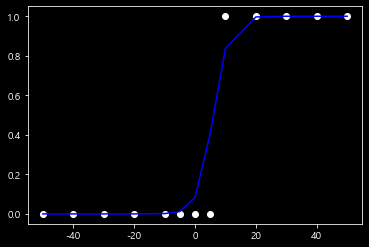

In [113]:
plt.plot(x, model.predict(x), color="b")
plt.scatter(x, y, color="w")

In [111]:
print(model.predict([1, 2, 3, 4, 4.5]))
print(model.predict([11, 21, 31, 41, 500]))

[[0.11951354]
 [0.16893   ]
 [0.23336375]
 [0.31311452]
 [0.35808378]]
[[0.88504624]
 [0.99771535]
 [0.9999596 ]
 [0.9999993 ]
 [1.        ]]


## 3-3. Multivariate Linear Regression 구현하기
- 중간 고사, 기말 고사, 그리고 추가 점수를 어떤 공식을 통해 최종 점수를 계산한 데이터가 있고, 그 규칙을 찾고싶다면 이제는 더 이상 독립 변수가 1개가 아닙니다.

In [212]:
x = np.array([[70, 85, 11],  [71, 89, 18], [50, 80, 20], [99, 20, 10], [50, 10, 10]])
y = np.array([73, 82, 72, 57, 34])

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=1, input_shape=(3,), activation="linear"))

model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.00001) , loss="mean_squared_error", metrics=["mse"])

hist = model.fit(x, y, batch_size=1, epochs=500, shuffle=False)

Epoch 1/500
5/5 [==============================] - 0s 2ms/step - loss: 11530.2520 - mse: 11530.2520
Epoch 2/500
5/5 [==============================] - 0s 4ms/step - loss: 2798.8584 - mse: 2798.8584
Epoch 3/500
5/5 [==============================] - 0s 2ms/step - loss: 1272.4995 - mse: 1272.4995
Epoch 4/500
5/5 [==============================] - 0s 2ms/step - loss: 877.7783 - mse: 877.7783
Epoch 5/500
5/5 [==============================] - 0s 2ms/step - loss: 695.5632 - mse: 695.5632
Epoch 6/500
5/5 [==============================] - 0s 2ms/step - loss: 573.0280 - mse: 573.0280
Epoch 7/500
5/5 [==============================] - 0s 2ms/step - loss: 478.7897 - mse: 478.7897
Epoch 8/500
5/5 [==============================] - 0s 2ms/step - loss: 403.3607 - mse: 403.3607
Epoch 9/500
5/5 [==============================] - 0s 2ms/step - loss: 342.2296 - mse: 342.2296
Epoch 10/500
5/5 [==============================] - 0s 2ms/step - loss: 292.4771 - mse: 292.4771
Epoch 11/500
5/5 [=============

5/5 [==============================] - 0s 2ms/step - loss: 43.6924 - mse: 43.6924
Epoch 171/500
5/5 [==============================] - 0s 2ms/step - loss: 43.5325 - mse: 43.5325
Epoch 172/500
5/5 [==============================] - 0s 2ms/step - loss: 43.3731 - mse: 43.3731
Epoch 173/500
5/5 [==============================] - 0s 2ms/step - loss: 43.2143 - mse: 43.2143
Epoch 174/500
5/5 [==============================] - 0s 2ms/step - loss: 43.0561 - mse: 43.0561
Epoch 175/500
5/5 [==============================] - 0s 2ms/step - loss: 42.8984 - mse: 42.8984
Epoch 176/500
5/5 [==============================] - 0s 2ms/step - loss: 42.7414 - mse: 42.7414
Epoch 177/500
5/5 [==============================] - 0s 2ms/step - loss: 42.5848 - mse: 42.5848
Epoch 178/500
5/5 [==============================] - 0s 1ms/step - loss: 42.4289 - mse: 42.4289
Epoch 179/500
5/5 [==============================] - 0s 2ms/step - loss: 42.2736 - mse: 42.2736
Epoch 180/500
5/5 [==============================] - 0

5/5 [==============================] - 0s 1ms/step - loss: 23.5936 - mse: 23.5936
Epoch 339/500
5/5 [==============================] - 0s 1ms/step - loss: 23.5072 - mse: 23.5072
Epoch 340/500
5/5 [==============================] - 0s 2ms/step - loss: 23.4212 - mse: 23.4212
Epoch 341/500
5/5 [==============================] - 0s 1ms/step - loss: 23.3354 - mse: 23.3354
Epoch 342/500
5/5 [==============================] - 0s 2ms/step - loss: 23.2500 - mse: 23.2500
Epoch 343/500
5/5 [==============================] - 0s 2ms/step - loss: 23.1649 - mse: 23.1649
Epoch 344/500
5/5 [==============================] - 0s 2ms/step - loss: 23.0801 - mse: 23.0801
Epoch 345/500
5/5 [==============================] - 0s 2ms/step - loss: 22.9956 - mse: 22.9956
Epoch 346/500
5/5 [==============================] - 0s 2ms/step - loss: 22.9114 - mse: 22.9114
Epoch 347/500
5/5 [==============================] - 0s 1ms/step - loss: 22.8275 - mse: 22.8275
Epoch 348/500
5/5 [==============================] - 0

## 3-4. Multivariate Logistic Regression 구현하기

In [46]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 1])

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=1, input_shape=(2,), activation="sigmoid"))

model.compile(optimizer="sgd", loss="binary_crossentropy", metrics=["binary_accuracy"])

hist = model.fit(x, y, batch_size=1, epochs=1200, shuffle=False)

Epoch 1/1200
4/4 [==============================] - 0s 2ms/step - loss: 0.4977 - binary_accuracy: 0.7500
Epoch 2/1200
4/4 [==============================] - 0s 1ms/step - loss: 0.4950 - binary_accuracy: 0.5000
Epoch 3/1200
4/4 [==============================] - 0s 1ms/step - loss: 0.4924 - binary_accuracy: 0.5000
Epoch 4/1200
4/4 [==============================] - 0s 1ms/step - loss: 0.4898 - binary_accuracy: 0.5000
Epoch 5/1200
4/4 [==============================] - 0s 997us/step - loss: 0.4874 - binary_accuracy: 0.5000
Epoch 6/1200
4/4 [==============================] - 0s 2ms/step - loss: 0.4849 - binary_accuracy: 0.5000
Epoch 7/1200
4/4 [==============================] - 0s 1ms/step - loss: 0.4825 - binary_accuracy: 0.5000
Epoch 8/1200
4/4 [==============================] - 0s 997us/step - loss: 0.4802 - binary_accuracy: 0.5000
Epoch 9/1200
4/4 [==============================] - 0s 997us/step - loss: 0.4779 - binary_accuracy: 0.5000
Epoch 10/1200
4/4 [==============================

4/4 [==============================] - 0s 2ms/step - loss: 0.3901 - binary_accuracy: 0.7500
Epoch 75/1200
4/4 [==============================] - 0s 1ms/step - loss: 0.3893 - binary_accuracy: 0.7500
Epoch 76/1200
4/4 [==============================] - 0s 2ms/step - loss: 0.3885 - binary_accuracy: 0.7500
Epoch 77/1200
4/4 [==============================] - 0s 1ms/step - loss: 0.3877 - binary_accuracy: 0.7500
Epoch 78/1200
4/4 [==============================] - 0s 2ms/step - loss: 0.3869 - binary_accuracy: 0.7500
Epoch 79/1200
4/4 [==============================] - 0s 997us/step - loss: 0.3861 - binary_accuracy: 0.7500
Epoch 80/1200
4/4 [==============================] - 0s 1ms/step - loss: 0.3854 - binary_accuracy: 0.7500
Epoch 81/1200
4/4 [==============================] - 0s 1ms/step - loss: 0.3846 - binary_accuracy: 0.7500
Epoch 82/1200
4/4 [==============================] - 0s 2ms/step - loss: 0.3838 - binary_accuracy: 0.7500
Epoch 83/1200
4/4 [==============================] - 0s 1m

4/4 [==============================] - 0s 1ms/step - loss: 0.3143 - binary_accuracy: 0.7500
Epoch 227/1200
4/4 [==============================] - 0s 1ms/step - loss: 0.3139 - binary_accuracy: 0.7500
Epoch 228/1200
4/4 [==============================] - 0s 1ms/step - loss: 0.3136 - binary_accuracy: 0.7500
Epoch 229/1200
4/4 [==============================] - 0s 997us/step - loss: 0.3132 - binary_accuracy: 0.7500
Epoch 230/1200
4/4 [==============================] - 0s 2ms/step - loss: 0.3129 - binary_accuracy: 0.7500
Epoch 231/1200
4/4 [==============================] - 0s 1ms/step - loss: 0.3126 - binary_accuracy: 0.7500
Epoch 232/1200
4/4 [==============================] - 0s 1ms/step - loss: 0.3122 - binary_accuracy: 0.7500
Epoch 233/1200
4/4 [==============================] - 0s 1ms/step - loss: 0.3119 - binary_accuracy: 0.7500
Epoch 234/1200
4/4 [==============================] - 0s 1ms/step - loss: 0.3115 - binary_accuracy: 0.7500
Epoch 235/1200
4/4 [==============================

4/4 [==============================] - 0s 2ms/step - loss: 0.2695 - binary_accuracy: 1.0000
Epoch 379/1200
4/4 [==============================] - 0s 2ms/step - loss: 0.2693 - binary_accuracy: 1.0000
Epoch 380/1200
4/4 [==============================] - 0s 5ms/step - loss: 0.2690 - binary_accuracy: 1.0000
Epoch 381/1200
4/4 [==============================] - 0s 2ms/step - loss: 0.2688 - binary_accuracy: 1.0000
Epoch 382/1200
4/4 [==============================] - 0s 1ms/step - loss: 0.2685 - binary_accuracy: 1.0000
Epoch 383/1200
4/4 [==============================] - 0s 2ms/step - loss: 0.2683 - binary_accuracy: 1.0000
Epoch 384/1200
4/4 [==============================] - 0s 2ms/step - loss: 0.2680 - binary_accuracy: 1.0000
Epoch 385/1200
4/4 [==============================] - 0s 2ms/step - loss: 0.2678 - binary_accuracy: 1.0000
Epoch 386/1200
4/4 [==============================] - 0s 2ms/step - loss: 0.2675 - binary_accuracy: 1.0000
Epoch 387/1200
4/4 [==============================] 

4/4 [==============================] - 0s 2ms/step - loss: 0.2359 - binary_accuracy: 1.0000
Epoch 530/1200
4/4 [==============================] - 0s 2ms/step - loss: 0.2358 - binary_accuracy: 1.0000
Epoch 531/1200
4/4 [==============================] - 0s 2ms/step - loss: 0.2356 - binary_accuracy: 1.0000
Epoch 532/1200
4/4 [==============================] - 0s 2ms/step - loss: 0.2354 - binary_accuracy: 1.0000
Epoch 533/1200
4/4 [==============================] - 0s 2ms/step - loss: 0.2352 - binary_accuracy: 1.0000
Epoch 534/1200
4/4 [==============================] - 0s 2ms/step - loss: 0.2350 - binary_accuracy: 1.0000
Epoch 535/1200
4/4 [==============================] - 0s 2ms/step - loss: 0.2348 - binary_accuracy: 1.0000
Epoch 536/1200
4/4 [==============================] - 0s 3ms/step - loss: 0.2346 - binary_accuracy: 1.0000
Epoch 537/1200
4/4 [==============================] - 0s 2ms/step - loss: 0.2344 - binary_accuracy: 1.0000
Epoch 538/1200
4/4 [==============================] 

4/4 [==============================] - 0s 1ms/step - loss: 0.2095 - binary_accuracy: 1.0000
Epoch 681/1200
4/4 [==============================] - 0s 5ms/step - loss: 0.2093 - binary_accuracy: 1.0000
Epoch 682/1200
4/4 [==============================] - 0s 2ms/step - loss: 0.2092 - binary_accuracy: 1.0000
Epoch 683/1200
4/4 [==============================] - 0s 2ms/step - loss: 0.2090 - binary_accuracy: 1.0000
Epoch 684/1200
4/4 [==============================] - 0s 1ms/step - loss: 0.2089 - binary_accuracy: 1.0000
Epoch 685/1200
4/4 [==============================] - 0s 2ms/step - loss: 0.2087 - binary_accuracy: 1.0000
Epoch 686/1200
4/4 [==============================] - 0s 2ms/step - loss: 0.2085 - binary_accuracy: 1.0000
Epoch 687/1200
4/4 [==============================] - 0s 3ms/step - loss: 0.2084 - binary_accuracy: 1.0000
Epoch 688/1200
4/4 [==============================] - 0s 1ms/step - loss: 0.2082 - binary_accuracy: 1.0000
Epoch 689/1200
4/4 [==============================] 

4/4 [==============================] - 0s 1ms/step - loss: 0.1880 - binary_accuracy: 1.0000
Epoch 833/1200
4/4 [==============================] - 0s 3ms/step - loss: 0.1879 - binary_accuracy: 1.0000
Epoch 834/1200
4/4 [==============================] - 0s 14ms/step - loss: 0.1877 - binary_accuracy: 1.0000
Epoch 835/1200
4/4 [==============================] - 0s 3ms/step - loss: 0.1876 - binary_accuracy: 1.0000
Epoch 836/1200
4/4 [==============================] - 0s 1ms/step - loss: 0.1875 - binary_accuracy: 1.0000
Epoch 837/1200
4/4 [==============================] - 0s 2ms/step - loss: 0.1874 - binary_accuracy: 1.0000
Epoch 838/1200
4/4 [==============================] - 0s 1ms/step - loss: 0.1872 - binary_accuracy: 1.0000
Epoch 839/1200
4/4 [==============================] - 0s 2ms/step - loss: 0.1871 - binary_accuracy: 1.0000
Epoch 840/1200
4/4 [==============================] - 0s 7ms/step - loss: 0.1870 - binary_accuracy: 1.0000
Epoch 841/1200
4/4 [==============================]

4/4 [==============================] - 0s 3ms/step - loss: 0.1705 - binary_accuracy: 1.0000
Epoch 983/1200
4/4 [==============================] - 0s 3ms/step - loss: 0.1704 - binary_accuracy: 1.0000
Epoch 984/1200
4/4 [==============================] - 0s 1ms/step - loss: 0.1703 - binary_accuracy: 1.0000
Epoch 985/1200
4/4 [==============================] - 0s 2ms/step - loss: 0.1702 - binary_accuracy: 1.0000
Epoch 986/1200
4/4 [==============================] - 0s 5ms/step - loss: 0.1701 - binary_accuracy: 1.0000
Epoch 987/1200
4/4 [==============================] - 0s 4ms/step - loss: 0.1700 - binary_accuracy: 1.0000
Epoch 988/1200
4/4 [==============================] - 0s 2ms/step - loss: 0.1699 - binary_accuracy: 1.0000
Epoch 989/1200
4/4 [==============================] - 0s 2ms/step - loss: 0.1698 - binary_accuracy: 1.0000
Epoch 990/1200
4/4 [==============================] - 0s 1ms/step - loss: 0.1697 - binary_accuracy: 1.0000
Epoch 991/1200
4/4 [==============================] 

4/4 [==============================] - 0s 1ms/step - loss: 0.1560 - binary_accuracy: 1.0000
Epoch 1132/1200
4/4 [==============================] - 0s 1ms/step - loss: 0.1559 - binary_accuracy: 1.0000
Epoch 1133/1200
4/4 [==============================] - 0s 1ms/step - loss: 0.1558 - binary_accuracy: 1.0000
Epoch 1134/1200
4/4 [==============================] - 0s 2ms/step - loss: 0.1557 - binary_accuracy: 1.0000
Epoch 1135/1200
4/4 [==============================] - 0s 1ms/step - loss: 0.1556 - binary_accuracy: 1.0000
Epoch 1136/1200
4/4 [==============================] - 0s 1ms/step - loss: 0.1556 - binary_accuracy: 1.0000
Epoch 1137/1200
4/4 [==============================] - 0s 1ms/step - loss: 0.1555 - binary_accuracy: 1.0000
Epoch 1138/1200
4/4 [==============================] - 0s 1ms/step - loss: 0.1554 - binary_accuracy: 1.0000
Epoch 1139/1200
4/4 [==============================] - 0s 1ms/step - loss: 0.1553 - binary_accuracy: 1.0000
Epoch 1140/1200
4/4 [=======================

## 3-5. Softmax Regression 구현하기

In [57]:
x_train.shape

(60000, 28, 28)

In [58]:
y_train.shape

(60000,)

In [201]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
model.add(tf.keras.layers.Dense(units=128, activation="relu"))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(units=10, activation="softmax"))

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

model.fit(x_train, y_train, epochs=5)

model.evaluate(x_test, y_test, verbose=2)

Epoch 1/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2993 - sparse_categorical_accuracy: 0.9124
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1437 - sparse_categorical_accuracy: 0.9573
Epoch 3/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.1079 - sparse_categorical_accuracy: 0.9671
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0880 - sparse_categorical_accuracy: 0.9730
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0755 - sparse_categorical_accuracy: 0.9765
313/313 - 0s - loss: 0.0701 - sparse_categorical_accuracy: 0.9777


[0.07009219378232956, 0.9776999950408936]

# 4. NLP using Tensorflow

## 4-1. 다층 퍼셉트론으로 20개의 뉴스 분류하기
- 사이킷런에서는 20개의 다른 주제를 가진 18,846개의 뉴스 그룹 이메일 데이터를 제공합니다.

In [142]:
%%time
news = fetch_20newsgroups(subset="train")

Wall time: 385 ms


- `subset="all"`을 통해 전체 데이터인 18,846개의 샘플을 다운로드할 수 있으며, `subset="train"`을 통해 훈련 데이터를, `subset="test"`를 통해 테스트 데이터를 다운로드할 수 있습니다.

In [143]:
#해당 데이터의 속성을 확인할 수 있습니다.
print(news.keys())

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])


- 해당 데이터는 `data`, `filenames`, `target_names`, `target`, `DESCR`, `description`이라는 6개 속성을 갖고 있습니다. 이 중 실제로 훈련에 사용할 속성은 이메일 본문인 `data`와 메일이 어떤 주제인지 기재된 숫자 레이블인 `target`입니다. 우선 훈련용 샘플의 개수를 보겠습니다.

In [144]:
print(f"훈련용 샘플의 개수 : {len(news['data'])}")

훈련용 샘플의 개수 : 11314


- `target_names`에는 20개의 주제의 이름을 담고있습니다. 어떤 주제가 있는지 확인해보겠습니다.

In [145]:
print(news["target_names"])

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


- 이번 챕터 실습의 목적은 테스트 데이터에서 이메일 본문을 보고 20개의 주제 중 어떤 주제인지를 맞추는 것입니다. 레이블인 target에는 총 0부터 19까지의 숫자가 들어가있는데 첫번째 샘플의 경우에는 몇 번 주제인지 확인해보겠습니다.

In [147]:
print(f"첫번째 샘플의 레이블 : {news['target'][0]}")

첫번째 샘플의 레이블 : 7


In [148]:
print(f"7번 레이블이 의미하는 주제 : {news['target_names'][7]}")

7번 레이블이 의미하는 주제 : rec.autos


In [149]:
print(news["data"][0])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [99]:
data = pd.DataFrame(news["data"], columns=["content"])
data["label"] = news["target"]

In [100]:
data.head()

,content,label
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14


In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11314 entries, 0 to 11313
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   11314 non-null  object
 1   target  11314 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 176.9+ KB


<AxesSubplot:>

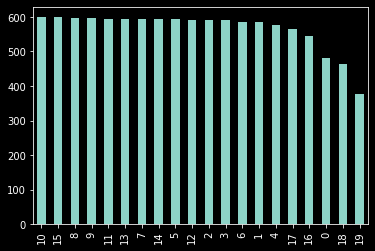

In [154]:
data["label"].value_counts().plot(kind="bar")

In [219]:
news_train = fetch_20newsgroups(subset="train", shuffle=True)
news_test = fetch_20newsgroups(subset="test", shuffle=True)

train_content = news_train["data"]
train_label = news_train["target"]
test_content = news_train["data"]
test_label = news_train["target"]

vocab_size = 10000
n_clss = 20

def prepare_data(ratings_train, ratings_test, mode):
    tkn = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size+1)
    tkn.fit_on_texts(ratings_train)
    x_train = tkn.texts_to_matrix(ratings_train, mode=mode)
    x_test = tkn.texts_to_matrix(ratings_test, mode=mode)
    return x_train, x_test, tkn.index_word

x_train, x_test, idx2word = prepare_data(train_content, test_content, "binary")
y_train = tf.keras.utils.to_categorical(train_label, n_clss)
y_test = tf.keras.utils.to_categorical(test_label, n_clss)

def fit_and_evaluate(x_train, y_train, x_test, y_test):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(units=256, input_shape=(vocab_size+1,), activation="relu"))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(units=128, activation="relu"))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(n_clss, activation="softmax"))

    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["categorical_accuracy"])
    
    hist = model.fit(x=x_train, y=y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.1)
    
    score = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
    return score[1]

In [220]:
modes = ["binary", "count", "tfidf", "freq"]

for mode in modes:
    x_train, x_test, _ = prepare_data(train_content, test_content, mode)
    score = fit_and_evaluate(x_train, y_train, x_test, y_test)
    
    print(f"{mode} 모드의 테스트 정확도 : {score:.1%}")

Epoch 1/5
80/80 [==============================] - 3s 37ms/step - loss: 2.3123 - categorical_accuracy: 0.3311 - val_loss: 1.0163 - val_categorical_accuracy: 0.8260
Epoch 2/5
80/80 [==============================] - 3s 34ms/step - loss: 0.8940 - categorical_accuracy: 0.7568 - val_loss: 0.4652 - val_categorical_accuracy: 0.8860
Epoch 3/5
80/80 [==============================] - 3s 35ms/step - loss: 0.4382 - categorical_accuracy: 0.8824 - val_loss: 0.3433 - val_categorical_accuracy: 0.9099
Epoch 4/5
80/80 [==============================] - 3s 35ms/step - loss: 0.2647 - categorical_accuracy: 0.9311 - val_loss: 0.3137 - val_categorical_accuracy: 0.9099
Epoch 5/5
89/89 [==============================] - 1s 12ms/step - loss: 0.0560 - categorical_accuracy: 0.9882
binary 모드의 테스트 정확도 : 98.8%
Epoch 1/5
80/80 [==============================] - 3s 39ms/step - loss: 2.8333 - categorical_accuracy: 0.2379 - val_loss: 1.7273 - val_categorical_accuracy: 0.7094
Epoch 2/5
80/80 [==========================

## 4-2. MLP로 네이버 영화 리뷰 분류하기

In [91]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
ratings_train = pd.read_table("ratings_train.txt", usecols=["document", "label"]).dropna()

urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")
ratings_test = pd.read_table("ratings_test.txt", usecols=["document", "label"]).dropna()

In [92]:
ratings_train.head()

,document,label
0,아 더빙.. 진짜 짜증나네요 목소리,0
1,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,너무재밓었다그래서보는것을추천한다,0
3,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [96]:
%%time
def okt_pos(doc):
    return ["/".join(t) for t in okt.pos(doc, stem=True, norm=True)]

if os.path.exists("train_docs.json"):
    with open("train_docs.json") as f:
        train_docs = json.load(f)
    with open("test_docs.json") as f:
        test_docs = json.load(f)
else:
    train_docs = [(okt_pos(row["document"]), row["label"]) for _, row in ratings_train.iterrows()]
    test_docs = [(okt_pos(row["document"]), row["label"]) for _, row in ratings_test.iterrows()]
    with open("train_docs.json", "w", encoding="utf-8") as f:
        json.dump(train_docs, f, ensure_ascii=False, indent="\t")
    with open("test_docs.json", "w", encoding="utf-8") as f:
        json.dump(test_docs, f, ensure_ascii=False, indent="\t")

(['아/Exclamation',
  '더빙/Noun',
  '../Punctuation',
  '진짜/Noun',
  '짜증나다/Adjective',
  '목소리/Noun'],
 0)
Wall time: 18min 6s


In [ ]:
%%time
def okt_pos(doc):
    return ["/".join(t) for t in okt.pos(doc, stem=True, norm=True)]

if os.path.exists("train_data.json"):
    with open("train_data.json") as f:
        train_data = json.load(f)
    with open("test_data.json") as f:
        test_data = json.load(f)
else:
    train_data = [(okt_pos(row["document"]), row["label"]) for _, row in ratings_train.iterrows()]
    test_data = [(okt_pos(row["document"]), row["label"]) for _, row in ratings_test.iterrows()]
    with open("train_data.json", "w", encoding="utf-8") as f:
        json.dump(train_data, f, ensure_ascii=False, indent="\t")
    with open("test_data.json", "w", encoding="utf-8") as f:
        json.dump(test_data, f, ensure_ascii=False, indent="\t")

pprint(train_data[0])

In [120]:
tokens = [doc for sample in train_data for doc in sample[0]]
text = nltk.Text(tokens, name="NMSC")

# 전체 토큰의 개수
print(len(text.tokens))
# 중복을 제외한 토큰의 개수
print(len(set(text.tokens)))            
# 출현 빈도가 높은 상위 토큰 10개
pprint(text.vocab().most_common(10))

2159921
49894
[('./Punctuation', 67778),
 ('영화/Noun', 50818),
 ('하다/Verb', 41209),
 ('이/Josa', 38540),
 ('보다/Verb', 38538),
 ('의/Josa', 30188),
 ('../Punctuation', 29055),
 ('가/Josa', 26627),
 ('에/Josa', 26468),
 ('을/Josa', 23118)]


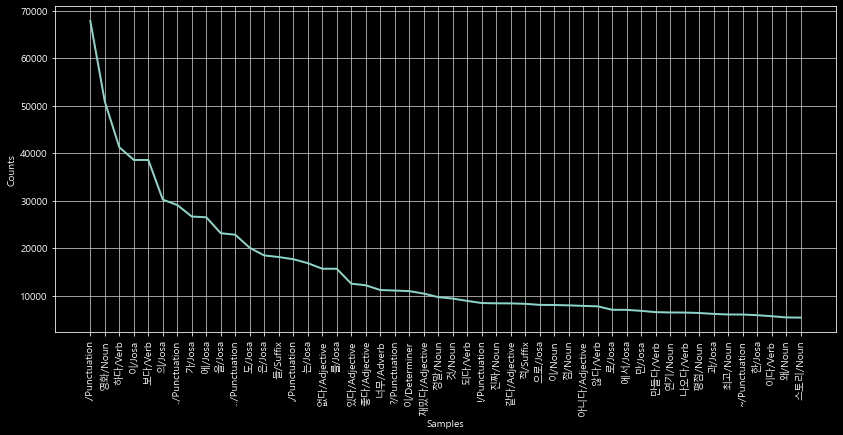

In [130]:
plt.figure(figsize=(14, 6))
text.plot(50)

In [108]:
"""
# 시간이 꽤 걸립니다! 시간을 절약하고 싶으면 most_common의 매개변수를 줄여보세요.
selected_words = [f[0] for f in text.vocab().most_common(10000)]

def term_frequency(doc):
    return [doc.count(word) for word in selected_words]

train_x = [term_frequency(d) for d, _ in train_docs]
test_x = [term_frequency(d) for d, _ in test_docs]
train_y = [c for _, c in train_docs]
test_y = [c for _, c in test_docs]
"""

'\n# 시간이 꽤 걸립니다! 시간을 절약하고 싶으면 most_common의 매개변수를 줄여보세요.\nselected_words = [f[0] for f in text.vocab().most_common(10000)]\n\ndef term_frequency(doc):\n    return [doc.count(word) for word in selected_words]\n\ntrain_x = [term_frequency(d) for d, _ in train_docs]\ntest_x = [term_frequency(d) for d, _ in test_docs]\ntrain_y = [c for _, c in train_docs]\ntest_y = [c for _, c in test_docs]\n'

In [109]:
"""
import numpy as np

x_train = np.asarray(train_x).astype("float32")
x_test = np.asarray(test_x).astype("float32")

y_train = np.asarray(train_y).astype("float32")
y_test = np.asarray(test_y).astype("float32")
"""

"\nimport numpy as np\n\nx_train = np.asarray(train_x).astype('float32')\nx_test = np.asarray(test_x).astype('float32')\n\ny_train = np.asarray(train_y).astype('float32')\ny_test = np.asarray(test_y).astype('float32')\n"

In [112]:
model = models.tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=64, input_shape=(10000,), activation="relu"))
model.add(tf.keras.layers.Dense(units=64, activation="relu"))
model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001), loss="binary_crossentropy", metrics=["binary_accuracy"])

model.fit(x_train, y_train, epochs=10, batch_size=512)

results = model.evaluate(x_test, y_test)

"\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Dense\nfrom tensorflow.keras import optimizers\nfrom tensorflow.keras import losses\nfrom tensorflow.keras import metrics\n\nmodel = models.Sequential()\nmodel.add(Dense(64, activation='relu', input_shape=(10000,)))\nmodel.add(Dense(64, activation='relu'))\nmodel.add(Dense(1, activation='sigmoid'))\n\nmodel.compile(optimizer=optimizers.RMSprop(lr=0.001),\n             loss=losses.binary_crossentropy,\n             metrics=[metrics.binary_accuracy])\n\nmodel.fit(x_train, y_train, epochs=10, batch_size=512)\nresults = model.evaluate(x_test, y_test)\n"

## 4-3. tf.keras.Sequential API vs. Functional API

### (1) tf.keras.Sequential API

In [124]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=3, input_shape=(4,), activation="softmax"))

- 앞에서 Keras를 사용하여 모델을 설계하는 방식을 tf.keras.Sequential API를 사용하였다고 합니다. 그런데 tf.keras.Sequential API는 여러층을 공유하거나 다양한 종류의 입력과 출력을 사용하는 등의 복잡한 모델을 만드는 일을 하기에는 한계가 있습니다. 이번에는 복잡한 모델을 생성할 수 있는 방식인 Functional API에 대해서 알아봅니다.
- Functional API는 각 층을 일종의 함수(function)로서 정의합니다. 그리고 각 함수를 조합하기 위한 연산자들을 제공하는데, 이를 이용하여 신경망을 설계합니다. Functional API로 FFNN, RNN 등 다양한 모델을 만들면서 기존의 tf.keras.Sequential API와의 차이를 이해해봅시다.

### (2) Functional API로 만든 모델

### 피드 포워드 신경망

In [123]:
inputs = tf.keras.Input(shape=(10,))

hidden1 = tf.keras.layers.Dense(64, activation="relu")(inputs)
hidden2 = tf.keras.layers.Dense(64, activation="relu")(hidden1)

output = tf.keras.layers.Dense(1, activation="sigmoid")(hidden2)

model = tf.keras.Model(inputs=inputs, outputs=output)

### 다중 입력을 받는 모델(tf.keras.Model that accepts multiple inputs)

In [130]:
# 두 개의 입력층을 정의
inputA = tf.keras.Input(shape=(64,))
inputB = tf.keras.Input(shape=(128,))

# 첫번째 입력층으로부터 분기되어 진행되는 인공 신경망을 정의
x = tf.keras.layers.Dense(16, activation="relu")(inputA)
x = tf.keras.layers.Dense(8, activation="relu")(x)
x = tf.keras.Model(inputs=inputA, outputs=x)

# 두번째 입력층으로부터 분기되어 진행되는 인공 신경망을 정의
y = tf.keras.layers.Dense(64, activation="relu")(inputB)
y = tf.keras.layers.Dense(32, activation="relu")(y)
y = tf.keras.layers.Dense(8, activation="relu")(y)
y = tf.keras.Model(inputs=inputB, outputs=y)

# 두개의 인공 신경망의 출력을 연결(concatenate)
result = tf.concat([x.output, y.output])

# 연결된 값을 입력으로 받는 밀집층을 추가(tf.keras.layers.Dense layer)
z = tf.keras.layers.Dense(2, activation="relu")(result)
# 선형 회귀를 위해 activation=linear를 설정
z = tf.keras.layers.Dense(1, activation="linear")(z)

# 결과적으로 이 모델은 두 개의 입력층으로부터 분기되어 진행된 후 마지막에는 하나의 출력을 예측하는 모델이 됨.
model = tf.keras.Model(inputs=[x.input, y.input], outputs=z)

# 5. soynlp

## 5-1. OOV 문제

In [3]:
print(okt.morphs("에이비식스 이대휘 1월 최애돌 기부 요정"))

NameError: name 'okt' is not defined

- 에이비식스는 아이돌의 이름이고, 이대휘는 에이비식스의 멤버이며, 최애돌은 최고로 애정하는 아이돌이라는 뜻이지만 위의 형태소 분석 결과에서는 전부 분리된 결과를 보여줍니다.
- 그렇다면 텍스트 데이터에서 특정 문자 시퀀스가 함께 자주 등장하는 빈도가 높고, 앞 뒤로 조사 또는 완전히 다른 단어가 등장하는 것을 고려해서 해당 문자 시퀀스를 형태소라고 판단하는 형태소 분석기라면 어떨까요?
- 예를 들어 에이비식스라는 문자열이 자주 연결되어 등장한다면 형태소라고 판단하고, 또한 에이비식스라는 단어 앞, 뒤에 "최고", "가수", "실력"과 같은 독립된 다른 단어들이 계속해서 등장한다면 에이비식스를 형태소로 파악하는 식이지요. 그리고 이런 아이디어를 가진 형태소 분석기가 soynlp입니다.
- soynlp는 품사 태깅, 형태소 분석 등을 지원하는 한국어 형태소 분석기입니다. 비지도 학습으로 형태소 분석을 한다는 특징을 갖고 있으며, 데이터에 자주 등장하는 단어들을 형태소로 분석합니다. soynlp 형태소 분석기는 내부적으로 단어 점수 표로 동작합니다. 이 점수는 응집 확률(cohesion probability)과 브랜칭 엔트로피(branching entropy)를 활용합니다.

In [34]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/lovit/soynlp/master/tutorials/2016-10-20.txt", filename="2016-10-20.txt")

('2016-10-20.txt', <http.client.HTTPMessage at 0x131981bfd08>)

다운로드 한 말뭉치를 문서 단위로 분리합니다.

In [35]:
from soynlp import DoublespaceLineCorpus

# 말뭉치에 대해서 다수의 문서로 분리
corpus = DoublespaceLineCorpus("2016-10-20.txt")

len(corpus)

30091

총 3만 91개의 문서가 존재합니다. 공백이 아닌 문서에 한해 상위 3개의 문서만 출력해봅시다.

In [72]:
i = 0
for document in corpus:
  if len(document) > 0:
    print(document)
    i = i+1
  if i == 3:
    break

19  1990  52 1 22
오패산터널 총격전 용의자 검거 서울 연합뉴스 경찰 관계자들이 19일 오후 서울 강북구 오패산 터널 인근에서 사제 총기를 발사해 경찰을 살해한 용의자 성모씨를 검거하고 있다 성씨는 검거 당시 서바이벌 게임에서 쓰는 방탄조끼에 헬멧까지 착용한 상태였다 독자제공 영상 캡처 연합뉴스  서울 연합뉴스 김은경 기자 사제 총기로 경찰을 살해한 범인 성모 46 씨는 주도면밀했다  경찰에 따르면 성씨는 19일 오후 강북경찰서 인근 부동산 업소 밖에서 부동산업자 이모 67 씨가 나오기를 기다렸다 이씨와는 평소에도 말다툼을 자주 한 것으로 알려졌다  이씨가 나와 걷기 시작하자 성씨는 따라가면서 미리 준비해온 사제 총기를 이씨에게 발사했다 총알이 빗나가면서 이씨는 도망갔다 그 빗나간 총알은 지나가던 행인 71 씨의 배를 스쳤다  성씨는 강북서 인근 치킨집까지 이씨 뒤를 쫓으며 실랑이하다 쓰러뜨린 후 총기와 함께 가져온 망치로 이씨 머리를 때렸다  이 과정에서 오후 6시 20분께 강북구 번동 길 위에서 사람들이 싸우고 있다 총소리가 났다 는 등의 신고가 여러건 들어왔다  5분 후에 성씨의 전자발찌가 훼손됐다는 신고가 보호관찰소 시스템을 통해 들어왔다 성범죄자로 전자발찌를 차고 있던 성씨는 부엌칼로 직접 자신의 발찌를 끊었다  용의자 소지 사제총기 2정 서울 연합뉴스 임헌정 기자 서울 시내에서 폭행 용의자가 현장 조사를 벌이던 경찰관에게 사제총기를 발사해 경찰관이 숨졌다 19일 오후 6시28분 강북구 번동에서 둔기로 맞았다 는 폭행 피해 신고가 접수돼 현장에서 조사하던 강북경찰서 번동파출소 소속 김모 54 경위가 폭행 용의자 성모 45 씨가 쏜 사제총기에 맞고 쓰러진 뒤 병원에 옮겨졌으나 숨졌다 사진은 용의자가 소지한 사제총기  신고를 받고 번동파출소에서 김창호 54 경위 등 경찰들이 오후 6시 29분께 현장으로 출동했다 성씨는 그사이 부동산 앞에 놓아뒀던 가방을 챙겨 오패산 쪽으로 도망간 후였다  김 경위는 오패산 터널 입구 오른쪽의 급경사에서 성씨에

soynlp는 비지도학습 형태소 분석기이므로 기존의 형태소 분석기와는 달리 학습 과정을 거쳐야 합니다. 이는 전체 코퍼스로부터 응집 확률과 브랜칭 엔트로피 단어 점수표를 만드는 과정이지요. WordExtractor.extract()를 통해서 전체 코퍼스에 대해 단어 점수표를 계산합니다.

In [73]:
from soynlp.word import WordExtractor
word_extractor = WordExtractor()
word_extractor.train(corpus)
word_score_table = word_extractor.extract()

training was done. used memory 5.186 Gb
all cohesion probabilities was computed. # words = 223348
all branching entropies was computed # words = 361598
all accessor variety was computed # words = 361598


## soynlp의 응집 확률(cohesion probability)

응집 확률은 내부 문자열(substring)이 얼마나 응집하여 자주 등장하는지를 판단하는 척도입니다. 응집 확률은 문자열을 문자 단위로 분리하여 내부 문자열을 만드는 과정에서 왼쪽부터 순서대로 문자를 추가하면서 각 문자열이 주어졌을 때 그 다음 문자가 나올 확률을 계산하여 누적곱을 한 값입니다. 이 값이 높을수록 전체 코퍼스에서 이 문자열 시퀀스는 하나의 단어로 등장할 가능성이 높습니다. 수식은 아래와 같습니다. 

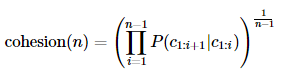

In [75]:
from IPython.display import Image

Image("https://wikidocs.net/images/page/84111/soynlp.png")

아직은 아리송 할 거에요. "반포한강공원에"라는 7의 길이를 가진 문자 시퀀스에 대해서 각 내부 문자열의 스코어를 구하는 과정은 아래와 같습니다.

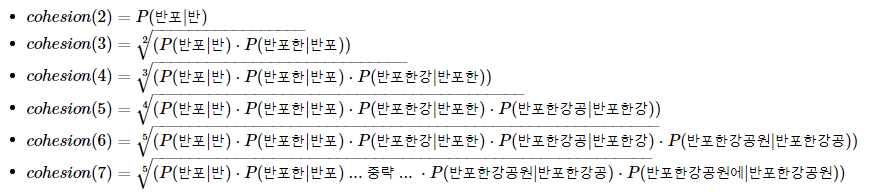

In [76]:
Image("https://wikidocs.net/images/page/84111/soynlp2.png")

실습을 통해 직접 응집 확률을 계산해보겠습니다.

In [79]:
word_score_table["반포한"].cohesion_forward

0.08838002913645132

In [80]:
word_score_table["반포한강"].cohesion_forward

0.19841268168224552

In [81]:
word_score_table["반포한강공"].cohesion_forward

0.2972877884078849

In [84]:
word_score_table["반포한강공원"].cohesion_forward

0.37891487632839754

In [88]:
word_score_table["반포한강공원에"].cohesion_forward

0.33492963377557666

## soynlp의 브랜칭 엔트로피(branching entropy)

Branching Entropy는 확률 분포의 엔트로피값을 사용합니다.  이는 주어진 문자열에서 얼마나 다음 문자가 등장할 수 있는지를 판단하는 척도입니다. 이해를 위해 퀴즈를 내보겠습니다. 제가 어떤 단어를 생각 중인데, 한 문자씩 말해드릴테니까 매번 다음 문자를 맞추는 것이 퀴즈입니다.

첫번째 문자는 "디"입니다. 다음에 등장할 문자를 맞춰보세요. 솔직히 가늠이 잘 안 가지요? "디"로 시작하는 단어가 얼마나 많은데요. 이걸 어떻게 맞추냐구요. 정답은 "스" 입니다.

이제 "디스"까지 나왔네요. "디스 "다음 문자는 뭘까요? 벌써 정답 단어를 예측한 분도 있을테고, 여전히 가늠이 잘 안가시는 분도 있을 거에요. "디스카운트"라는 단어가 있으니까 "카"일까? 아니면 "디스코드"라는 단어가 있으니까 "코"인가? 생각해보니 "디스코"가 정답일 수도 있겠네요. 그러면 "코"인가? "디스아너드"라는 게임이 있으니까 "아"? 전부 땡땡땡! 이 단어들을 생각하신 분들은 전부 틀렸습니다. 정답은 "플"이었습니다.

"디스플"까지 왔습니다. 다음 문자 맞춰보세요. 이제 좀 명백해지는군요. 이 정도 되면 헷갈리시는 분들은 거의 없을거에요. 정답은 "레"입니다. "디스플레" 다음에는 어떤 문자일까요? 너무 명백해서 문제라고 보기도 어려워졌어요. 정답은 "이"입니다. 제가 생각한 단어는 "디스플레이"였습니다!

저는 지금 브랜칭 엔트로피를 시뮬레이션한 겁니다. 브랜칭 엔트로피를 주어진 문자 시퀀스에서 다음 문자 예측을 위해 헷갈리는 정도로 비유해봅시다. 브랜칭 엔트로피의 값은 하나의 완성된 단어에 가까워질수록 문맥으로 인해 점점 정확히 예측할 수 있게 되면서 점점 줄어듭니다. 실습해볼게요.

In [86]:
word_score_table["디스"].right_branching_entropy

1.6371694761537934

In [87]:
word_score_table["디스플"].right_branching_entropy

-0.0

"디스" 다음에는 다양한 문자가 올 수 있으니까 1.63이라는 값을 가지는 반면, "디스플"이라는 문자열 다음에는 다음 문자로 "레"가 오는 것이 너무나 명백하기 때문에 0이란 값을 가집니다.

In [89]:
word_score_table["디스플레"].right_branching_entropy

-0.0

In [91]:
word_score_table["디스플레이"].right_branching_entropy

3.1400392861792916

갑자기 값이 급증합니다. 그 이유는 문자 시퀀스 "디스플레이"라는 문자 시퀀스 다음에는 조사나 다른 단어와 같은 다양한 경우가 있을 수 있기 때문입니다. 이는 하나의 단어가 끝나면 그 경계 부분부터 다시 브랜칭 엔트로피 값이 증가하게 됨을 의미합니다. 그리고 이 값으로 단어를 판단하는 것이 가능하겠죠?

## soynlp의 L tokenizer

한국어는 띄어쓰기 단위로 나눈 어절 토큰은 주로 L 토큰 + R 토큰의 형식을 가질 때가 많습니다. 예를 들어서 "공원에"는 "공원 + 에"로 나눌 수 있겠지요. 또는 "공부하는"은 "공부 + 하는"으로 나눌 수도 있을 것입니다. L 토크나이저는 L 토큰 + R 토큰으로 나누되, 분리 기준을 점수가 가장 높은 L 토큰을 찾아내는 원리를 가지고 있습니다.

In [93]:
from soynlp.tokenizer import LTokenizer

scores = {word:score.cohesion_forward for word, score in word_score_table.items()}
l_tokenizer = Ltf.keras.preprocessing.text.Tokenizer(scores=scores)
l_tokenizer.tokenize("국제사회와 우리의 노력들로 범죄를 척결하자", flatten=False)

[('국제사회', '와'), ('우리', '의'), ('노력', '들로'), ('범죄', '를'), ('척결', '하자')]

## 최대 점수 토크나이저

최대 점수 토크나이저는 띄어쓰기가 되지 않는 문장에서 점수가 높은 글자 시퀀스를 순차적으로 찾아내는 토크나이저입니다. 띄어쓰기가 되어 있지 않은 문장을 넣어서 점수를 통해 토큰화 된 결과를 보겠습니다.

In [94]:
from soynlp.tokenizer import MaxScoreTokenizer

maxscore_tokenizer = MaxScoretf.keras.preprocessing.text.Tokenizer(scores=scores)
maxscore_tokenizer.tokenize("국제사회와우리의노력들로범죄를척결하자")

['국제사회', '와', '우리', '의', '노력', '들로', '범죄', '를', '척결', '하자']